# 1.导入依赖包

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py, os
from tensorflow.keras import callbacks
import tensorflow as tf
import torch
import random
import pickle
import matplotlib.pyplot as plt
import pywt
# -*- coding: utf-8 -*-
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from att import Attention

from tensorflow.keras.layers import GRU, Bidirectional
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout, Flatten,BatchNormalization
from tensorflow.keras import layers
import tensorflow as tf   
tf.get_logger().setLevel('ERROR')

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# 2.导入数据集

In [4]:
Label_material = {'gravel':0, 'M1(gravel+sand)':1, 'M2(sand+silicarock)':2, 'M3(gravel+silicarock)':3, 'regolith':5, 'sand':4, 'silicarock':6}

In [5]:
def plot_signal_decomp(data, w, title, tag):
        """Decompose and plot a signal S.
        S = An + Dn + Dn-1 + ... + D1
        """
        ca = []  # 近似分量
        cd = []  # 细节分量
        w = pywt.Wavelet(w)
        if tag=='vibration':
            a = data
            for i in range(2):
                (a, d) = pywt.dwt(a, w, pywt.Modes.smooth)
                ca.append(a)
                cd.append(d)
        elif tag=='fusion':
            for i in range(9):
                (a, d) = pywt.dwt(data, w, pywt.Modes.smooth)
                ca.append(a)
                cd.append(d)
        rec_a = []
        rec_d = []
        for i, coeff in enumerate(ca):
            coeff_list = [coeff, None] + [None] * i
            rec_a.append(pywt.waverec(coeff_list, w))  # 重构
            
        for i, coeff in enumerate(cd):
            coeff_list = [None, coeff] + [None] * i
            rec_d.append(pywt.waverec(coeff_list, w))
        return rec_a, rec_d

def Cal(data, length):
    data = list(data)
    ind = data.index(max(data))
    if (length/2) <= ind <= (len(data)-(length/2)):
        return np.array(data[int(ind-(length/2)): int(ind+(length/2))])
    elif ind<(length/2):
        return np.array(data[: length])
    elif len(data) - ind<(length/2):
        return np.array(data[-length: ])
    else:
         print('error!!')

def PrePro(x):
    scaler = Normalizer().fit(x)
    testX = scaler.transform(x)
    return [testX]

In [6]:
def FeaturesAccquir(path):
    Materials = os.listdir(path)
    labels = []
    Feature = np.empty(shape=(1, 1, 3600))
    for mater_name in tqdm(Materials):        
        path_material_ = os.path.join(path, mater_name)
        wave_list = os.listdir(path_material_)
        for name_wave in wave_list:
            signal=[]
            labels.append(Label_material[mater_name])
            wave_path_sigle = os.path.join(path_material_, name_wave)
            Wavelet = 'coif8'
            data = np.loadtxt(wave_path_sigle, dtype=object)
            
            An, D = plot_signal_decomp(data, Wavelet, "DWT: Signal irregularity", 'fusion') 
            Data = np.concatenate((An, D))
            length = 200
            for sig in Data:
                signal.extend(Cal(sig, length))
            y = PrePro(np.array(signal).reshape(1,-1))
            Feature = np.vstack((Feature, y))

    return Feature[1:], labels

In [7]:
path_FI = r'D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\data\5fold'
# List= os.listdir(path_FI)
train_dir = os.path.join(path_FI, 'train')
test_dir = os.path.join(path_FI, 'test_add')

In [8]:
from tqdm import tqdm
from sklearn import preprocessing
import threading

In [9]:
# x_train, y_train =  FeaturesAccquir(train_dir)
# x_test, y_test =  FeaturesAccquir(test_dir)

In [10]:
class Train_Test(threading.Thread):
    def __init__(self, path):
        super(Train_Test, self).__init__()
        self.path = path
    def run(self):
        print('开始转换！')
        self.result = FeaturesAccquir(self.path)
        print('转换结束！')
    def get_result(self):
        try:  
            return self.result  
        except Exception as e:  
            return None

thread1 = Train_Test(train_dir)
thread2 = Train_Test(test_dir)

thread_lists = [thread1, thread2]
for thread in thread_lists:
    thread.start()
thread.join()

开始转换！
开始转换！


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:36<00:00, 132.04s/it]

转换结束！



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [25:34<00:00, 219.21s/it]


转换结束！


In [11]:
x_train, y_train  =  thread1.get_result()
x_test, y_test =  thread2.get_result()

In [12]:
np.array(x_test).shape, np.array(y_test).shape

((634, 1, 3600), (634,))

### 训练集

In [13]:
from collections import Counter
# print('train:',Counter(list(y_train)),'\n'*2, 'test:',Counter(list(y_test)))
print( 'test:',Counter(list(y_test)))

test: Counter({0: 213, 4: 211, 1: 210})


# 3.定义模型

### BiGRU+Attention

In [14]:
# 模型结构：双向GRU + Attention + FC
def ABRNN():
    inputs = Input(shape=(1, 3600, ), name="input")
    lstm = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True), name="bi-lstm")(inputs)
    gru = Bidirectional(GRU(128, dropout=0.2, return_sequences=True), name="bi-gru")(inputs)
    
    attention1 = Attention(32, name="attention1")(lstm)
    attention2 = Attention(32, name="attention2")(gru)
#     output = GlobalAveragePooling2D()(x)

    output = layers.concatenate([attention1, attention2], axis=-1)
    output = Dense(7, activation='softmax', name="dense")(output)
    model = Model(inputs, output)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    model.build((1, 3600, )) 
    return model
model = ABRNN()

In [15]:
# plot_model(model, to_file='./ImageRecord/ModelStructure'+'/'+NAME+'.png', show_shapes=True, dpi=1000)
# plot_model(model, show_shapes = True)

In [16]:
def Shulffle(x,y):
    np.random.seed(200)
    np.random.shuffle(x) 
    np.random.seed(200)
    np.random.shuffle(y) 
    return x,y
x_train, y_train = Shulffle(x_train, y_train)
x_test, y_test = Shulffle(x_test, y_test)

In [17]:
import glob
import warnings, time
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

seed = 42  # 随机种子
np.random.seed(seed)  # 生成固定的随机数
num_k = 5  # 多少折
# 整个数据集(自己定义)
X, Y = x_train, np.array(y_train)
kfold = StratifiedKFold(n_splits=num_k, shuffle=True, random_state=seed) 

In [19]:
results = []
NAME='ABRNN'
k = 0#新建文件夹命名
for train, test in kfold.split(X, Y):
    model = ABRNN()
    k+=1
    path = os.path.join(r'D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold'+'/'+NAME, str(k))
    if not os.path.exists(path):
         os.makedirs(path)
    filepath = os.path.join(path,NAME+'-val_acc{val_acc:.4f}-{epoch:02d}.hdf5')
    checkpoint  = ModelCheckpoint(filepath=filepath,verbose=1, save_best_only=True, monitor='val_acc', mode='max')
    earlystopper = EarlyStopping( monitor='val_loss',patience=5,verbose=2, mode = 'min')

    history=model.fit(X[train], Y[train], 
                      batch_size=10, epochs=1000,
                      validation_data=(X[test], Y[test]), 
                      verbose=2,callbacks=[earlystopper,checkpoint])
    scores = model.evaluate(x_test, y_test, verbose=2)
    results.append(scores)

Train on 2973 samples, validate on 744 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.62903, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\1\ABRNN-val_acc0.6290-01.hdf5
2973/2973 - 5s - loss: 1.1981 - acc: 0.5180 - val_loss: 0.9785 - val_acc: 0.6290
Epoch 2/1000

Epoch 00002: val_acc improved from 0.62903 to 0.64919, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\1\ABRNN-val_acc0.6492-02.hdf5
2973/2973 - 2s - loss: 0.9226 - acc: 0.6266 - val_loss: 0.9521 - val_acc: 0.6492
Epoch 3/1000

Epoch 00003: val_acc improved from 0.64919 to 0.67339, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\1\ABRNN-val_acc0.6734-03.hdf5
2973/2973 - 2s - loss: 0.8424 - acc: 0.6700 - val_loss: 0.8533 - val_acc: 0.6734
Epoch 4/1000

Epoch 00004: val_acc did not improve from 0.67339
2973/2973 - 2s - lo

Epoch 17/1000

Epoch 00017: val_acc improved from 0.76882 to 0.77554, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\2\ABRNN-val_acc0.7755-17.hdf5
2973/2973 - 2s - loss: 0.5150 - acc: 0.8100 - val_loss: 0.5616 - val_acc: 0.7755
Epoch 18/1000

Epoch 00018: val_acc did not improve from 0.77554
2973/2973 - 2s - loss: 0.4998 - acc: 0.8066 - val_loss: 0.5472 - val_acc: 0.7742
Epoch 19/1000

Epoch 00019: val_acc did not improve from 0.77554
2973/2973 - 2s - loss: 0.4874 - acc: 0.8133 - val_loss: 0.5606 - val_acc: 0.7715
Epoch 20/1000

Epoch 00020: val_acc did not improve from 0.77554
2973/2973 - 2s - loss: 0.4739 - acc: 0.8251 - val_loss: 0.5443 - val_acc: 0.7634
Epoch 21/1000

Epoch 00021: val_acc did not improve from 0.77554
2973/2973 - 2s - loss: 0.4673 - acc: 0.8308 - val_loss: 0.5810 - val_acc: 0.7702
Epoch 22/1000

Epoch 00022: val_acc improved from 0.77554 to 0.79973, saving model to D:\Triage\Bayesian_Network\NewTIM\Reco

Epoch 20/1000

Epoch 00020: val_acc did not improve from 0.80350
2974/2974 - 2s - loss: 0.4672 - acc: 0.8241 - val_loss: 0.5570 - val_acc: 0.7900
Epoch 21/1000

Epoch 00021: val_acc did not improve from 0.80350
2974/2974 - 2s - loss: 0.4584 - acc: 0.8262 - val_loss: 0.5486 - val_acc: 0.7927
Epoch 22/1000

Epoch 00022: val_acc did not improve from 0.80350
2974/2974 - 2s - loss: 0.4391 - acc: 0.8322 - val_loss: 0.5572 - val_acc: 0.7873
Epoch 23/1000

Epoch 00023: val_acc improved from 0.80350 to 0.81292, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\3\ABRNN-val_acc0.8129-23.hdf5
2974/2974 - 2s - loss: 0.4380 - acc: 0.8410 - val_loss: 0.5440 - val_acc: 0.8129
Epoch 24/1000

Epoch 00024: val_acc improved from 0.81292 to 0.81561, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\3\ABRNN-val_acc0.8156-24.hdf5
2974/2974 - 2s - loss: 0.4245 - acc: 0.8373 - val_loss: 0.5

Epoch 27/1000

Epoch 00027: val_acc did not improve from 0.80754
2974/2974 - 2s - loss: 0.4021 - acc: 0.8423 - val_loss: 0.5757 - val_acc: 0.7954
Epoch 28/1000

Epoch 00028: val_acc did not improve from 0.80754
2974/2974 - 2s - loss: 0.3768 - acc: 0.8547 - val_loss: 0.5958 - val_acc: 0.8035
Epoch 29/1000

Epoch 00029: val_acc did not improve from 0.80754
2974/2974 - 2s - loss: 0.3693 - acc: 0.8625 - val_loss: 0.6870 - val_acc: 0.7497
Epoch 00029: early stopping
634/634 - 0s - loss: 0.7011 - acc: 0.7413
Train on 2974 samples, validate on 743 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.60027, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold/ABRNN\5\ABRNN-val_acc0.6003-01.hdf5
2974/2974 - 7s - loss: 1.1734 - acc: 0.5504 - val_loss: 1.0053 - val_acc: 0.6003
Epoch 2/1000

Epoch 00002: val_acc improved from 0.60027 to 0.64065, saving model to D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2

# 4.模型测试

In [45]:
# np.array(x_train).shape, np.array(y_train).shape, np.array(x_test).shape, np.array(y_test).shape

In [16]:
# saved_weight = r"./weights - 副本/Attention+GRU_coif8-val_acc0.8763-280.hdf5"
# saved_weight = r"./weights - 副本/GRU_coif8-val_acc0.7858-719.hdf5"
saved_weight = r"./weights - 副本/LSTM_coif8-val_acc0.7616-284.hdf5"
# saved_weight = r"./weights - 副本/SimpleRNN_coif8-val_acc0.7384-961.hdf5"


In [20]:
# saved_weight = r"./weights/Attention+LSTM_coif8-val_acc0.8746-768.hdf5"
saved_weight = r"D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold\ABRNN\3\ABRNN-val_acc0.8331-31.hdf5"


In [22]:
# 评估模型,不输出预测结果
# model = Bi_GRU()
model.load_weights(saved_weight)
loss,accuracy = model.evaluate(x_test, y_test, verbose=2, batch_size=8)
print('\ntest loss',loss)
print('accuracy',accuracy)

634/634 - 0s - loss: 0.4260 - acc: 0.8328

test loss 0.4259954511014633
accuracy 0.8328076


In [24]:
import time
start = time.perf_counter()

y_probs = model.predict(x_test)
y_pred= np.argmax(y_probs,axis=1)
end = time.perf_counter()

Y_test, Y_pred = y_test, y_pred
Report = metrics.classification_report(Y_test, Y_pred, digits=4, output_dict=True)
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, digits=4))
print("每条耗时: %.4f ms" % ((end - start)*1000/len(y_pred)))   
print("总耗时为: %.4f min" % ((end - start)/60)) 

              precision    recall  f1-score   support

           0     0.9315    0.9577    0.9444       213
           1     0.9545    0.6000    0.7368       210
           2     0.0000    0.0000    0.0000         0
           3     0.0000    0.0000    0.0000         0
           4     0.7306    0.9384    0.8216       211
           5     0.0000    0.0000    0.0000         0

    accuracy                         0.8328       634
   macro avg     0.4361    0.4160    0.4171       634
weighted avg     0.8723    0.8328    0.8348       634

每条耗时: 1.5607 ms
总耗时为: 0.0165 min


In [26]:
df = pd.DataFrame([Report['weighted avg']])
df.insert(loc=0, column='accuracy', value=Report['accuracy'])

In [27]:
df

,accuracy,precision,recall,f1-score,support
0,0.832808,0.872284,0.832808,0.834789,634


In [57]:
import time
from sklearn.metrics import classification_report
path_weight0 = r'D:\Triage\Bayesian_Network\NewTIM\Recognition\Experiment\weights\Revise2\Vibration\5fold'+'/'+NAME
List = os.listdir(path_weight0)
Results = []
for ind, i in enumerate(List):
    df = pd.DataFrame()
    path_weight1 = glob.glob(os.path.join(path_weight0, i) + '\*.hdf5')
    model.load_weights(path_weight1[0])
    y_probs = model.predict(x_test)
    y_pred= np.argmax(y_probs,axis=1)
    Report = metrics.classification_report(Y_test, y_pred, digits=4, output_dict=True)
    df = pd.DataFrame([Report['weighted avg']])
    df.insert(loc=0, column='accuracy', value=Report['accuracy'])
    
    result = SenSpec(y_test, y_pred)
    Results.append(result)
    print(result)

[0.9096891202022113, 0.9017693767819407, 0.8359621451104101, 0.8602288115584585]
[0.9250166684910786, 0.8976155722251032, 0.8785488958990536, 0.8856667227429068]
[0.8951178735981052, 0.872283700287494, 0.832807570977918, 0.8347889682450559]
[0.8976853187911115, 0.8847619971496941, 0.8123028391167192, 0.8395055556115999]
[0.909308481525341, 0.8871983361705367, 0.8517350157728707, 0.8595418801500287]


In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, matthews_corrcoef

def SenSpec(Y_test, y_predict):
    matrix4 = confusion_matrix(Y_test,y_predict)
    accuracy = np.diag(matrix4).sum()/matrix4.sum()
#     print('ACC_TRUE：%.2f'%(accuracy*100))
    FP4, FN4, TP4, TN4 = TFPN(matrix4)
    VALUE4 = Metrics(FP4, FN4, TP4, TN4)  # ACC, TPR,TNR,G_Mean,F1_Score,PPV,NPV
    n_list = matrix4.sum(axis=1)
    value=[]
    for index1, i in enumerate(VALUE4):
        value.append(CI(i, n_list))
    return value
        
# 2-TP/TN/FP/FN的计算
def TFPN(matrix):
    FP = matrix.sum(axis=0) - np.diag(matrix)  
    FN = matrix.sum(axis=1) - np.diag(matrix)
    TP = np.diag(matrix)
    TN = matrix.sum() - (FP + FN + TP)
    return FP, FN, TP, TN
# 3-其他的性能参数的计算
def Metrics(FP, FN, TP, TN):
    ACC = (TP+TN)/(TP+TN+FP+FN) # accuracy of each class
    Recall = TP/(TP+FN) # Sensitivity/ hit rate/ recall/ true positive rate
    TNR = TN/(TN+FP) # Specificity/ true negative rate
    Precision = TP/(TP+FP) # Precision/ positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out/ false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1_Score = 2*(Precision*Recall)/(Precision+Recall)
    return ACC, Precision, Recall, F1_Score
def CI(acc_list, n_list):
    acc_list = np.array(acc_list)
    n_list = np.array(n_list)    
    valid_acc_list = acc_list[~np.isnan(acc_list)]
    valid_n_list = n_list[~np.isnan(acc_list)]
    avg_acc = np.average(valid_acc_list, weights=valid_n_list)
    return avg_acc

In [59]:
# result = SenSpec(Y_test, Y_pred)
df2 = pd.DataFrame(Results, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
df2

,Accuracy,Precision,Recall,F1-Score
0,0.909689,0.901769,0.835962,0.860229
1,0.925017,0.897616,0.878549,0.885667
2,0.895118,0.872284,0.832808,0.834789
3,0.897685,0.884762,0.812303,0.839506
4,0.909308,0.887198,0.851735,0.859542


In [57]:
import time
start = time.perf_counter()

y_probs = model.predict(x_test)
y_pred= np.argmax(y_probs,axis=1)
end = time.perf_counter()

y_true = y_test

print("每条耗时: %.4f ms" % ((end - start)*1000/len(y_pred)))   
print("总耗时为: %.4f min" % ((end - start)/60)) 

每条耗时: 0.2633 ms
总耗时为: 0.0049 min


In [58]:
from sklearn.metrics import confusion_matrix

labels_name = ("Gravel", "M1", "M2", "M3", "Sand", "Regolith", "SilicaRock")
matrix = confusion_matrix(y_true, y_pred)

In [59]:
def plot_confusion_matrix(matrix, labels_name, title, cmap=plt.cm.Blues):#cmap='Blues'
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(matrix, interpolation='nearest',cmap=cmap)    # 在特定的窗口上显示图像
    plt.title(NAME, fontdict={'family': 'Times New Roman', 'size': 20, 'weight'  : "bold"})    # 图像标题
#     plt.colorbar()
    
    
    bwith = 3 #边框宽度设置为2
    ax = plt.gca()#获取边框
#     ax.spines['top'].set_color('red')  # 设置上‘脊梁’为红色
#     ax.spines['right'].set_color('none')  # 设置上‘脊梁’为无色
    ax.spines['bottom'].set_linewidth(bwith)
    ax.spines['left'].set_linewidth(bwith)
    ax.spines['top'].set_linewidth(bwith)
    ax.spines['right'].set_linewidth(bwith)
    
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=0)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    
    plt.tick_params(labelsize=10, width=1)
    
    plt.rcParams['font.sans-serif']=['Times New Roman'] # ['SimSun']宋体；['SimHei']黑体，有很多自己都可以设置
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.ylabel('True label', fontdict={'family': 'Times New Roman','weight' : "bold", 'size': 18})    
    plt.xlabel('Predicted label', fontdict={'family': 'Times New Roman', 'weight'  : "bold", 'size': 18})
    plt.tight_layout()

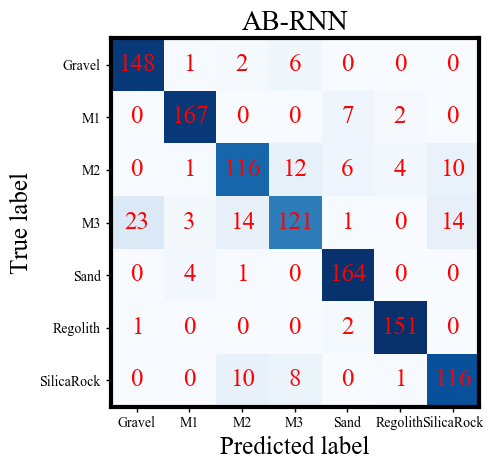

In [60]:
for i in range(len(matrix)):
    for j in range(len(matrix)):
        plt.annotate(matrix[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center',
                     weight = "bold", color = "r", fontsize=18, family = "Times New Roman")
plot_confusion_matrix(matrix, labels_name , "Confusion Matrix" )

plt.savefig(r'./ImageRecord/FusionMatrix'+'/'+NAME + '.svg', bbox_inches='tight' ,format='svg',transparent=True, dpi=200)
plt.show()

In [61]:
from sklearn import metrics

y_test    = y_test
y_predict = y_pred
 
a= metrics.accuracy_score(y_test, y_predict) #预测准确率输出

b = metrics.precision_score(y_test,y_predict,average='macro') #预测宏平均精确率输出
c = metrics.precision_score(y_test, y_predict, average='micro') #预测微平均精确率输出
d = metrics.precision_score(y_test, y_predict, average='weighted') #预测加权平均精确率输出
  
e = metrics.recall_score(y_test,y_predict,average='macro')#预测宏平均召回率输出
f = metrics.recall_score(y_test,y_predict,average='micro')#预测微平均召回率输出
g = metrics.recall_score(y_test,y_predict,average='micro')#预测加权平均召回率输出
h = metrics.f1_score(y_test,y_predict,labels=[0, 1,2,3,4,5,6],average='weighted')#预测加权平均f1-score输出
 
i = metrics.confusion_matrix(y_test,y_predict)#混淆矩阵输出
j = metrics.classification_report(y_test, y_predict,digits=4)#分类报告输出

save_path_ =r'./ImageRecord/metrics/txt'+'/'+NAME
if not os.path.exists(save_path_):
     os.makedirs(save_path_)
record_ = [a, i, j]
for i_ in record_:
    with open(save_path_+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

In [62]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [63]:
Y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = Y_test.shape[1]

In [64]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_probs[:, i])   
    #Y_test样例真实标签，y_score学习器预测的样例的概率 
    roc_auc[i] = auc(fpr[i], tpr[i])   
    #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标）


In [65]:
Y_test, y_probs

(array([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]),
 array([[1.00000000e+00, 1.05261426e-23, 3.48574903e-17, ...,
         1.32043369e-18, 6.42100162e-21, 2.54285391e-18],
        [1.00000000e+00, 1.22241520e-30, 1.46512147e-09, ...,
         8.82740848e-20, 9.01468206e-11, 2.31701594e-12],
        [9.99992490e-01, 4.05015642e-20, 1.48985754e-10, ...,
         1.36358660e-10, 1.55203528e-16, 3.66886599e-12],
        ...,
        [0.00000000e+00, 1.21411635e-28, 1.04234595e-14, ...,
         0.00000000e+00, 2.33219085e-25, 1.00000000e+00],
        [8.95602305e-24, 9.85940997e-31, 2.32493605e-07, ...,
         2.47568068e-36, 1.47938681e-19, 9.99993801e-01],
        [0.00000000e+00, 7.79530545e-27, 4.43351817e-14, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=float32))

In [66]:
# Plot all ROC curves
lw=1.5

colors = cycle(['aqua', 'darkorange', 'r', 'b', 'g', 'pink', 'gray'])
material = ['gravel', 'M1', 'M2', 'M3', 'sand', 'regolith', 'silicarock']
Score_ = []

In [77]:
save_path = r'./ImageRecord/ROC/txtRecord'
save_path_ = os.path.join(save_path, NAME+'/'+'ROC')
if not os.path.exists(save_path_):
    os.makedirs(save_path_)

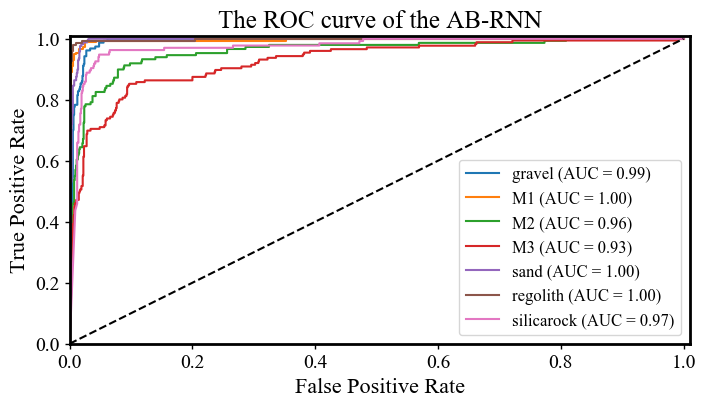

In [78]:
plt.figure(1, figsize=(8,4))

for i, color in zip(range(n_classes), colors):
    np.savetxt(save_path_ +'/'+ material[i] +'_ROC.txt', np.column_stack((fpr[i],tpr[i])),fmt='%.6f %.6f')

    plt.plot(fpr[i], tpr[i], lw=1.5,
             label='{0} (AUC = {1:0.2f})'
             ''.format(material[i], roc_auc[i]))
    Score_.append(roc_auc[i])

bwith = 2 #边框宽度设置为2
ax = plt.gca()#获取边框
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0,1.01])
plt.ylim([0.0,1.01])
plt.xlabel('False Positive Rate', fontdict={'family': 'Times New Roman', 'size': 16, 'weight'  : "bold"})
plt.ylabel('True Positive Rate', fontdict={'family': 'Times New Roman', 'size': 16, 'weight'  : "bold"})
plt.title('The ROC curve of the '+ NAME, fontdict={'family': 'Times New Roman', 'size': 18, 'weight'  : "bold"})#SCNN
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rc('legend', fontsize= 12)
plt.tick_params(labelsize=14, width=1)

plt.legend(loc="lower right")
plt.savefig(r'./ImageRecord/ROC'+'/'+NAME+'_ROC.svg',format='svg', bbox_inches='tight', transparent=True, dpi=200)
plt.show()

## PR曲线

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle


In [80]:
y_test_, y_score_ = Y_test, y_probs

In [81]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i],recall[i],_ = precision_recall_curve(y_test_[:,i],y_score_[:,i])
    average_precision[i] = average_precision_score(y_test_[:,i],y_score_[:,i])
    
precision["micro"],recall["micro"],_ = precision_recall_curve(y_test_.ravel(),y_score_.ravel())
average_precision["micro"] = average_precision_score(y_test_,y_score_,average="micro") 

In [82]:
# Materials = {0:'gravel', 1:'M1(gravel+sand)', 2:'M2(sand+silicarock)',3:'M3(gravel+silicarock)', 4:'sand', 5:'regolith', 6:'silicarock'}
Materials = {0:'gravel', 1:'M1', 2:'M2',3:'M3', 4:'sand', 5:'regolith', 6:'silicarock'}


In [83]:
save_path = r'./ImageRecord/ROC/txtRecord'
save_path_ = os.path.join(save_path, NAME+'/'+'PR')
if not os.path.exists(save_path_):
    os.makedirs(save_path_)

<Figure size 640x480 with 0 Axes>

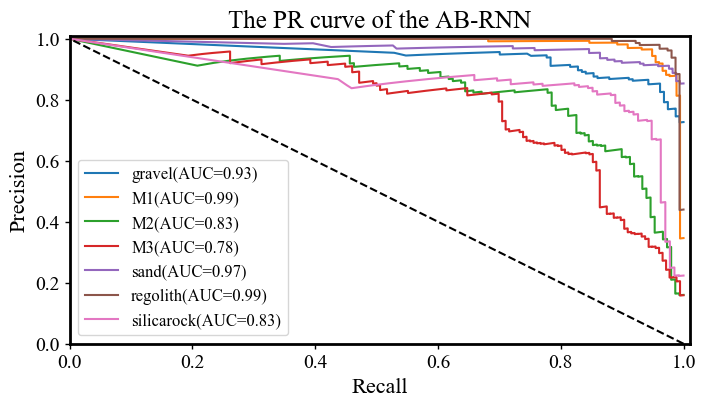

In [84]:
plt.clf()
plt.figure(2, figsize=(8,4))
# plt.plot(recall["micro"],precision["micro"],label = "micro_average P_R(area={0:0.2f})".format(average_precision["micro"]))
for i in range(n_classes):
#     np.savetxt(save_path_ +'/'+ material[i] +'_PR.txt', np.column_stack((recall[i],precision[i])),fmt='%.6f %.6f')
    plt.plot(recall[i],precision[i],label = "{0}(AUC={1:0.2f})".format(Materials[i],average_precision[i]))

plt.plot( [1, 0], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0,1.01])
plt.ylim([0.0,1.01])

bwith = 2 #边框宽度设置为2
ax = plt.gca()#获取边框
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)

plt.xlabel('Recall', fontdict={'family': 'Times New Roman', 'size': 16, 'weight'  : "bold"})
plt.ylabel('Precision', fontdict={'family': 'Times New Roman', 'size': 16, 'weight'  : "bold"})
plt.title('The PR curve of the '+ NAME, fontdict={'family': 'Times New Roman', 'size': 18, 'weight'  : "bold"})#SCNN
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rc('legend', fontsize= 12)
plt.tick_params(labelsize=14, width=1)

plt.legend(loc="lower left")

plt.savefig(r'./ImageRecord/PR'+'/'+NAME+'_PR.svg',format='svg', bbox_inches='tight', transparent=True, dpi=200)
plt.show()

In [36]:
import matplotlib.pyplot as plt

In [37]:
(history.history).keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [38]:
type(history.history['acc'])

list

In [ ]:
import os
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

dic = {0:'acc', 1:'val_acc', 2:'loss', 3:'val_loss'}
for index, name_metrics in enumerate([acc, val_acc, loss, val_loss]):
    save_path = r'./ImageRecord/loss_acc'+'/'+NAME
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    with open( save_path +'/'+ dic[index] + '.txt','a') as f:
        for a in name_metrics:
            f.write(str(a)+'\n')

In [39]:
# Network = 'SimpleRNN'
save_path = r'./ImageRecord/metrics/txt'
save_path_ = os.path.join(save_path, NAME)
if not os.path.exists(save_path_):
    os.makedirs(save_path_)
np.savetxt(save_path_+'/'+ 'accuracy.txt', np.array(history.history['acc']) )

np.savetxt(save_path_+'/'+ 'val_accuracy.txt', history.history['val_acc'])
np.savetxt(save_path_+'/'+ 'loss.txt', history.history['loss'])
np.savetxt(save_path_+'/'+ 'val_loss.txt', history.history['val_loss'])

1116/1116 - 0s - loss: 1.2690 - acc: 0.8808
测试集的准确度 0.8808244


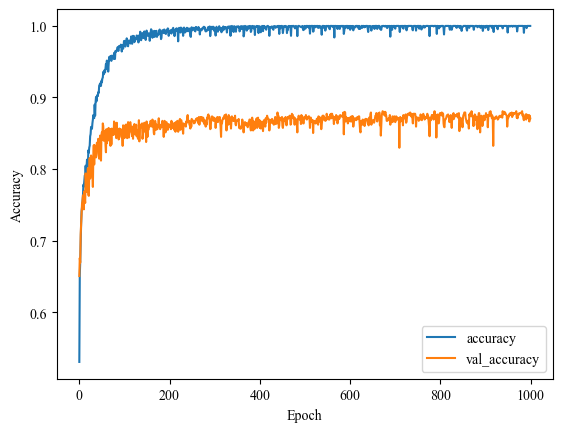

In [40]:
# 评估模型
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim()
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("测试集的准确度", test_acc)
plt.savefig(os.path.join(save_path,NAME)+'/'+NAME+'_accuracy'+str(np.round(test_acc,4))+'_acc.png')

plt.show()

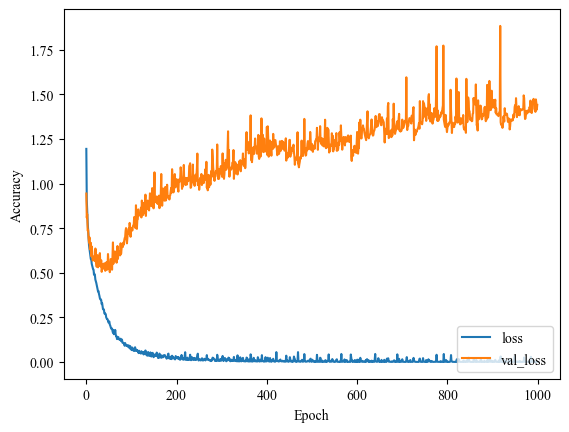

1116/1116 - 0s - loss: 1.2690 - acc: 0.8808
测试集的准确度 0.8808244


In [41]:
# 评估模型
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim()
plt.legend(loc='lower right')
plt.savefig(os.path.join(save_path,NAME)+'/'+NAME+'_accuracy'+'_loss.png')

plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("测试集的准确度", test_acc)
